In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/Applied Machine Learning
data_path = 'assets/dataset.xlsx'

/content/drive/MyDrive/Applied Machine Learning


![](https://static.timesofisrael.com/www/uploads/2020/07/iStock-1214535321.jpg)

> # **Applied Machine Learning - COVID19 Blood Test Classifier**
**Table of contents**
*   Section 1 - Paper Implementation
  *   Install Dependencies
  *   Importing Libaries
  *   Data pre-processing
    **   Cleaning Rows and Columns
    **   Label Encoder
    **   Iterative Imputer
  *   Data Visualization
  *   Data Augmentation
  *   Training and Testing Models
    **   Normalize Features
    **   Nested K-Fold Cross Validation
    **   Logistic Regression
    **   Random Forest
    **   XGBoost
*   Section 2 - Feature Engineering
  *   Logistic Regression
  *   Random Forest
  *   XGBoost
*   Section 3 - Additional Models
  *   CatBoost
  *   LightGBM
*   Section 4 - Model Explaniation using SHAP
  *   RFC
  *   XGBoost
  *   CatBoost
  *   LightGBM

**Background**

The World Health Organization (WHO) characterized the COVID-19, caused by the SARS-CoV-2, as a pandemic on March 11, while the exponential increase in the number of cases was risking to overwhelm health systems around the world with a demand for ICU beds far above the existing capacity, with regions of Italy being prominent examples.

Brazil recorded the first case of SARS-CoV-2 on February 26, and the virus transmission evolved from imported cases only, to local and finally community transmission very rapidly, with the federal government declaring nationwide community transmission on March 20.

Until March 27, the state of São Paulo had recorded 1,223 confirmed cases of COVID-19, with 68 related deaths, while the county of São Paulo, with a population of approximately 12 million people and where Hospital Israelita Albert Einstein is located, had 477 confirmed cases and 30 associated death, as of March 23. Both the state and the county of São Paulo decided to establish quarantine and social distancing measures, that will be enforced at least until early April, in an effort to slow the virus spread.

One of the motivations for this challenge is the fact that in the context of an overwhelmed health system with the possible limitation to perform tests for the detection of SARS-CoV-2, testing every case would be impractical and tests results could be delayed even if only a target subpopulation would be tested.



**Dataset**

This dataset contains anonymized data from patients seen at the Hospital Israelita Albert Einstein, at São Paulo, Brazil, and who had samples collected to perform the SARS-CoV-2 RT-PCR and additional laboratory tests during a visit to the hospital.

All data were anonymized following the best international practices and recommendations. All clinical data were standardized to have a mean of zero and a unit standard deviation.

## **Section 1** - Paper Implementation

### **Install Dependencies**

In [ ]:
!pip install catboost
!pip install shap

     |████████████████████████████████| 67.3MB 50kB/s 
     |████████████████████████████████| 358kB 11.5MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491620 sha256=6165ac5867d1f9fdc3ada84ab0081a857cbcf17f47e4c36382b7af6976deb3fa
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


### **Importing Libaries**

In [ ]:
# data processing
import pandas as pd
import numpy as np
import scipy.stats as sp
from imblearn.over_sampling import SVMSMOTE
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import IterativeImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import fbeta_score, make_scorer

# model explanation
import shap

# data visualization
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline

# defines the layout to the plotting
sns.set_context('paper', font_scale=1.5)
sns.set_style('whitegrid')

# scoring
from sklearn.metrics import confusion_matrix,recall_score, classification_report, auc, roc_curve,roc_auc_score, fbeta_score

# model processing
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# other tools
import time
from joblib import dump, load

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
df_covid = pd.read_excel(data_path)
df_covid.head()

,Patient ID,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Serum Glucose,Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,CoronavirusNL63,Rhinovirus/Enterovirus,Mycoplasma pneumoniae,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2,Neutrophils,...,Urine - Esterase,Urine - Aspect,Urine - pH,Urine - Hemoglobin,Urine - Bile pigments,Urine - Ketone Bodies,Urine - Nitrite,Urine - Density,Urine - Urobilinogen,Urine - Protein,Urine - Sugar,Urine - Leukocytes,Urine - Crystals,Urine - Red blood cells,Urine - Hyaline cylinders,Urine - Granular cylinders,Urine - Yeasts,Urine - Color,Partial thromboplastin time (PTT),Relationship (Patient/Normal),International normalized ratio (INR),Lactic Dehydrogenase,"Prothrombin time (PT), Activity",Vitamin B12,Creatine phosphokinase (CPK),Ferritin,Arterial Lactic Acid,Lipase dosage,D-Dimer,Albumin,Hb saturation (arterial blood gases),pCO2 (arterial blood gas analysis),Base excess (arterial blood gas analysis),pH (arterial blood gas analysis),Total CO2 (arterial blood gas analysis),HCO3 (arterial blood gas analysis),pO2 (arterial blood gas analysis),Arteiral Fio2,Phosphor,ctO2 (arterial blood gas analysis)
0,44477f75e8169d2,13,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,126e9dd13932f68,17,negative,0,0,0,0.236515,-0.02234,-0.517413,0.010677,0.102004,0.318366,-0.95079,-0.09461,-0.223767,-0.292269,1.482158,0.166192,0.357547,-0.625073,-0.140648,not_detected,not_detected,not_detected,not_detected,not_detected,detected,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,-0.619086,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,a46b4402a0e5696,8,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,f7d619a94f97c45,5,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,d9e41465789c2b5,15,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,detected,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
relevant_columns = [
    'SARS-Cov-2 exam result',
    'Hematocrit',
    'Hemoglobin',
    'Platelets',
    'Red blood Cells',
    'Lymphocytes',
    'Leukocytes',
    'Basophils',
    'Eosinophils',
    'Monocytes',
    'Neutrophils',
    'Creatinine',
    'Urea',
    'Potassium',
    'Sodium',
    'Aspartate transaminase',
    'Alanine transaminase',
    'Lactic Dehydrogenase',
    'Proteina C reativa mg/dL',
    'Mean platelet volume ',
    'Red blood cell distribution width (RDW)',
    'Mean corpuscular hemoglobin (MCH)',
    'Mean corpuscular hemoglobin concentration\xa0(MCHC)'
]

df_covid = df_covid[relevant_columns]

### Data Pre-processing

In [ ]:
def drop_by_data_threshold(df,threshold,axis):
    print(f'threshold (%) = {threshold * 100}')
    if axis == 'row': axis = 1
    elif axis == 'col' or axis == 'column': axis = 0

    max_values = df.shape[axis]
    value_threshold = int(threshold * max_values)
    mask_values_to_keep = df.count(axis = axis) >= value_threshold
    print('threshold (data points) =',value_threshold)
    if axis == 1: return df[mask_values_to_keep]
    elif axis == 0: return df.loc[:,mask_values_to_keep.values]

#### **Cleaning**
Drop columns with less than **5%** of available data and rows with less than **10%** of available features.

In [ ]:
df_covid_clean_col = drop_by_data_threshold(df_covid, threshold = 0.05, axis = 'column')
df_covid_clean_row = drop_by_data_threshold(df_covid_clean_col, threshold = 0.1, axis = 'row')

threshold (%) = 5.0
threshold (data points) = 282
threshold (%) = 10.0
threshold (data points) = 2


In [ ]:
df_covid_clean = df_covid_clean_row.copy()

In [ ]:
def get_categorical_features(df,sort = True):
    categorical_columns = df.dtypes[df.dtypes == object].index
    if sort: return np.sort(categorical_columns)
    return categorical_columns
categorical_columns = get_categorical_features(df_covid_clean)

In [ ]:
class_label = 'SARS-Cov-2 exam result'
irrelevant_columns = np.delete(categorical_columns, np.where(categorical_columns == class_label))
df_covid_clean.drop(columns = irrelevant_columns, inplace=True)

####**Label Encoder**

In [ ]:
df_covid_clean.loc[df_covid_clean[class_label] == 'positive',class_label] = 1
df_covid_clean.loc[df_covid_clean[class_label] == 'negative',class_label] = 0

In [ ]:
#final_df.to_csv('assets/dataset_preprocessed.csv',index = False)

In [ ]:
final_df = df_covid_clean
final_df.columns = df_covid_clean.columns

In [ ]:
final_df

,SARS-Cov-2 exam result,Hematocrit,Hemoglobin,Platelets,Red blood Cells,Lymphocytes,Leukocytes,Basophils,Eosinophils,Monocytes,Neutrophils,Creatinine,Urea,Potassium,Sodium,Proteina C reativa mg/dL,Mean platelet volume,Red blood cell distribution width (RDW),Mean corpuscular hemoglobin (MCH),Mean corpuscular hemoglobin concentration (MCHC)
1,0,0.236515,-0.022340,-0.517413,0.102004,0.318366,-0.094610,-0.223767,1.482158,0.357547,-0.619086,2.089928,1.198059,-0.305787,0.862512,-0.147895,0.010677,-0.625073,-0.292269,-0.950790
8,0,-1.571682,-0.774212,1.429667,-0.850035,-0.005738,0.364550,-0.223767,1.018625,0.068652,-0.127395,-1.838623,-0.067309,0.930020,0.503132,-0.286986,-1.672222,-0.978899,0.178175,3.331071
15,0,-0.747693,-0.586244,-0.429480,-1.361315,-1.114514,-0.884923,0.081693,-0.666950,1.276759,0.880570,-0.908177,-0.811643,0.435697,-0.215628,NaN,-0.213711,-1.067355,1.746323,0.542882
18,0,0.991838,0.792188,0.072992,0.542763,0.045436,-0.211488,-0.834685,-0.709090,-0.220244,0.265957,NaN,NaN,NaN,NaN,-0.487674,-0.550290,0.171035,0.334989,-0.452899
22,0,0.190738,-0.147652,-0.668155,-0.127191,0.002791,-1.132592,0.387152,-0.709090,2.012129,-0.422410,-0.908177,-1.332677,-0.552949,-0.575008,NaN,1.020415,0.613318,-0.083183,-1.249524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5602,0,0.190738,0.165628,-0.102873,0.384090,-1.583611,-0.328365,-0.834685,0.892207,1.066653,1.118221,0.470262,0.379292,0.188535,-5.246946,3.627427,0.908221,0.347948,-0.449085,-0.054585
5614,0,-0.289922,-0.523588,0.663397,0.754327,-1.532437,1.569499,0.081693,-0.540532,1.670707,1.134611,0.504723,-0.067309,-0.552949,-0.215628,5.733660,-0.774677,0.967144,-2.174047,-1.050367
5615,0,0.717175,1.105468,-0.492289,0.613284,0.002791,-0.550988,-0.223767,-0.709090,0.909074,-0.061837,-0.494645,-0.365042,0.435697,0.143752,0.561468,-0.213711,-1.155812,0.700891,1.538664
5618,0,-3.242548,-2.779203,-1.773594,-3.318285,-1.830953,-1.733675,-1.140144,-0.582671,1.381812,1.552548,0.470262,2.240127,-0.305787,-1.293767,0.609157,-0.550290,-0.448160,2.059952,1.538664


### Data Visualization

In [ ]:
def plot_pie(data, feature):
      # data to plot
    labels =  'Negative Cases', 'Positive Cases',
    colors = ['lightcoral', 'lightskyblue']
    # explode 1st slice
    explode = (0.1, 0) 

    fig, axs = plt.subplots(figsize=(14, 7))
    plt.pie(data[feature].value_counts(), autopct='%1.1f%%', shadow=True, startangle=140, explode=explode, labels=labels, colors=colors,)
    plt.legend()
    plt.axis('equal')

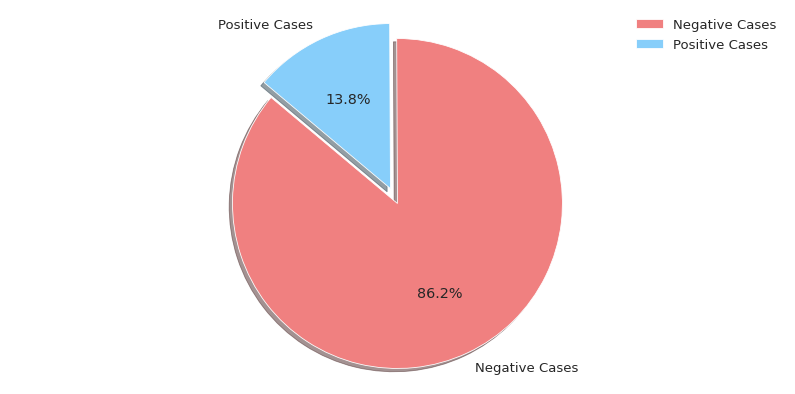

In [ ]:
plot_pie(final_df, class_label)

In [ ]:
y = final_df[class_label]
X = final_df.drop(class_label, axis=1)

The dataset was very umbalanced and that made the learning process of the algorithm difficult to perform and the performance was at it's best about 74% f1-score.

In [ ]:
from sklearn.preprocessing import LabelEncoder
y = LabelEncoder().fit_transform(y)

In [ ]:
X, y = pd.DataFrame(data=X, columns=final_df.drop(class_label, axis=1).columns) ,pd.DataFrame(data=y, columns=[class_label])

In [ ]:
scaler = MinMaxScaler()
scaler.fit(X)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

###**IterativeImputer**

Multivariate imputer that estimates each feature from all the others.

A strategy for imputing missing values by modeling each feature with missing values as a function of other features in a round-robin fashion.

In [ ]:
def imputer(train, test):
    imp_mean = IterativeImputer(random_state=0,verbose=0)
    imp_mean.fit(train)
    return pd.DataFrame(imp_mean.transform(train)), pd.DataFrame(imp_mean.transform(test))

X_train, X_test = imputer(X_train, X_test)

[IterativeImputer] Early stopping criterion not reached.


In [ ]:
X_train.columns = X.columns
X_test.columns = X.columns

### Data Augmentation

**SMOTE**

![](https://www.researchgate.net/publication/319413978/figure/fig2/AS:533727585333249@1504261980375/Data-augmentation-using-semantic-preserving-transformation-for-SBIR.png)

this technique, minority class data are synthetically over-sampled, presenting for the training subset the same proportion of instances for the positive and the
negative class.

In [ ]:
X_train, y_train = SVMSMOTE().fit_resample(X_train, y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.


In [ ]:
X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)

Checking the balance of the data after pergorming over-sampling with the SMOTE algorithm

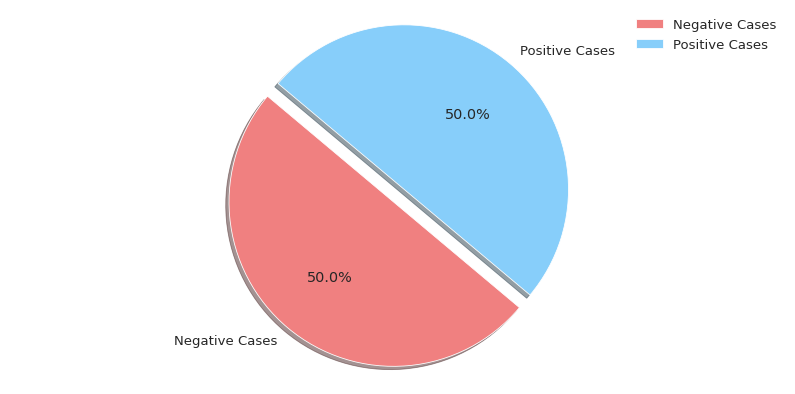

In [ ]:
try:
  plot_pie(pd.DataFrame(y_train),pd.DataFrame(y_train).columns[0])
except: pass

### Training and Testing Models
Let us try the following models:

- Random Forest
- XGBoost
- Logistic Regression

Scoring function will be F1, since it is more costly to have false negatives than false positives

#### **Normalize Features**

In [ ]:
X_train_norm = pd.DataFrame(data=scaler.transform(X_train),columns=X_train.columns)
X_test_norm = pd.DataFrame(data=scaler.transform(X_test),columns=X_test.columns)

In [ ]:
f1_scorer = make_scorer(fbeta_score, beta=1)

#### **Nested K-Fold Cross Validation**

![](https://hackingmaterials.lbl.gov/automatminer/_images/cv_nested.png)

In [ ]:
def model_fit_with_grid_search_nested_cv(model,parameters,X,y,folds = 5, score = 'accuracy',verbose = 0):
    start = time.time()

    cv_inner = StratifiedKFold(n_splits=folds*2, shuffle=True, random_state=1)

    grid_search = GridSearchCV(
        estimator = model,
        param_grid = parameters,
        cv = cv_inner,
        scoring = score, 
        verbose = verbose,
        n_jobs = 1,
        refit=True
    )
    grid_search.fit(X,y)

    cv_outer = StratifiedKFold(n_splits=folds, shuffle=True, random_state=1)
    scores = cross_val_score(grid_search, X, y, scoring=score, cv=cv_outer, n_jobs=-1)

    if verbose > 0:
        print("--- Ellapsed time: %s seconds ---" % (time.time() - start))
        print('Best params: ',grid_search.best_params_)
        print('Best score (%s)' % score,grid_search.best_score_)
        print('Nested Cross Validation Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))
    return grid_search.best_estimator_,grid_search.best_params_, grid_search.best_score_

In [ ]:
def predict(model,X,y):
    df_result = pd.DataFrame(columns = ['TrueClass','Predicted'])
    df_result.Predicted = model.predict(X)
    df_result.TrueClass = y.values.ravel()
    return df_result

In [ ]:
def plot_confusion_matrix(df,title,labels = ['Negative', 'Positive'],dataset_type = 'Test'):
    conf_matrix = confusion_matrix(df.TrueClass, df.Predicted)
    plt.figure(figsize=(8, 8))
    sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt="d");
    plt.title('{0} - Confusion matrix - {1} set'.format(title,dataset_type), fontsize = 20)
    plt.xlabel('Predicted class')
    plt.ylabel('True class')
    plt.show()
    return conf_matrix.ravel()

In [ ]:
def plot_ROC(model,model_name,X_test,y_test):
    
    naive_probs = [0 for _ in range(len(y_test))]
    
    probs = model.predict_proba(X_test)
    probs = probs[:, 1]

    naive_auc = roc_auc_score(y_test, naive_probs)
    model_auc = roc_auc_score(y_test, probs)

    print('No Skill: ROC AUC=%.3f' % (naive_auc))
    print(model_name,': ROC AUC=%.3f' % (model_auc))

    naive_fpr, naive_tpr, _ = roc_curve(y_test, naive_probs)
    model_fpr, model_tpr, _ = roc_curve(y_test, probs)
    
    plt.plot(naive_fpr, naive_tpr, linestyle='--', label='Naive')
    plt.plot(model_fpr, model_tpr, marker='.', label=model_name)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

In [ ]:
def evalute_model_performance(model,model_name,X,y):
    df_result = predict(model,X,y)
    class_report = classification_report(df_result.TrueClass, df_result.Predicted,output_dict = True)
    accuracy = class_report['accuracy']
    recall = class_report['macro avg']['recall']
    precision = class_report['macro avg']['precision']
    f1 = class_report['macro avg']['f1-score']
    f2 = fbeta_score(df_result.TrueClass, df_result.Predicted,beta = 2, average='macro')
    print('')
    print('Performance Report: ')
    print('Accuracy: %1.3f' % accuracy)
    print('Recall: %1.3f' % recall)
    print('Precision: %1.3f' % precision)
    print('F1: %1.3f' % f1)
    print('F2: %1.3f' % f2)
    print('')

    plot_confusion_matrix(df_result,model_name)

    try:
        plot_ROC(model, model_name, X, y)
    except:
        print('Could not print ROC AUC curve.')

#### 1 **Logistic Regression**
![](https://i.ytimg.com/vi/FEksNK_i7lQ/maxresdefault.jpg)

In [ ]:
#model's hyperparameters
logistic_regression_params = {
    'C' : [0.1,1,10,100],
    'penalty' : ['l2', 'elasticnet'],
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'class_weight':[None,'balanced']
}

# Creating a Grid Search for hyperparameter tuning
best_lr,best_lr_params,best_lr_score = model_fit_with_grid_search_nested_cv(
    LogisticRegression(),
    logistic_regression_params,
    X_train_norm.values,
    y_train.values.ravel(),
    folds = 5,
    score = f1_scorer,
    verbose = 1)

Fitting 10 folds for each of 80 candidates, totalling 800 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Valu

--- Ellapsed time: 30.689993143081665 seconds ---
Best params:  {'C': 100, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}
Best score (make_scorer(fbeta_score, beta=1)) 0.8859639581694376
Nested Cross Validation Accuracy: 0.884 (0.018)



Performance Report: 
Accuracy: 0.842
Recall: 0.790
Precision: 0.701
F1: 0.729
F2: 0.760



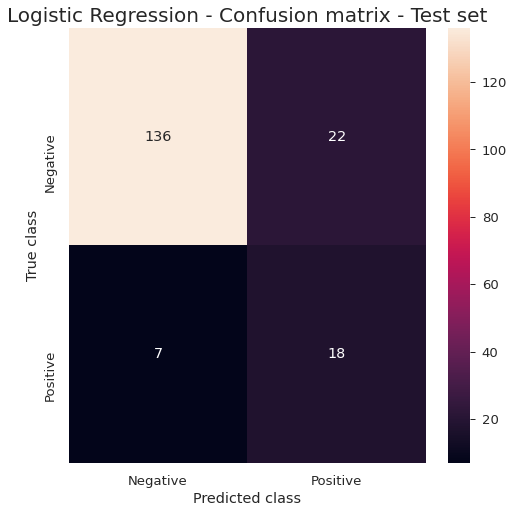

No Skill: ROC AUC=0.500
Logistic Regression : ROC AUC=0.886


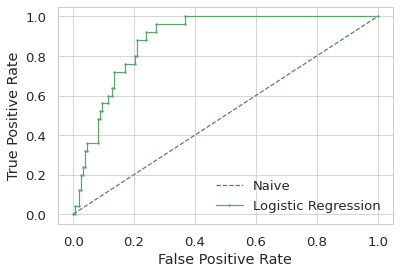

In [ ]:
evalute_model_performance(best_lr, 'Logistic Regression',X_test_norm, y_test)

#### 2 **Random Forest**

![](https://mljar.com/images/machine-learning/random_forest_logo.png)

In [ ]:
#model's hyperparameters
random_forest_params = {
    'n_estimators' : list(range(10,101,10)),
    'max_depth':[2**i for i in range(1,7)],
}

best_random_forest,best_random_forest_params,best_random_forest_score = model_fit_with_grid_search_nested_cv(
    RandomForestClassifier(),
    random_forest_params,
    X_train_norm.values,
    y_train.values.ravel(),
    folds = 5,
    score = f1_scorer,
    verbose = 1)

Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:  1.4min finished


--- Ellapsed time: 413.4005181789398 seconds ---
Best params:  {'max_depth': 16, 'n_estimators': 50}
Best score (make_scorer(fbeta_score, beta=1)) 0.9515794322636427
Nested Cross Validation Accuracy: 0.953 (0.011)



Performance Report: 
Accuracy: 0.858
Recall: 0.648
Precision: 0.688
F1: 0.664
F2: 0.654



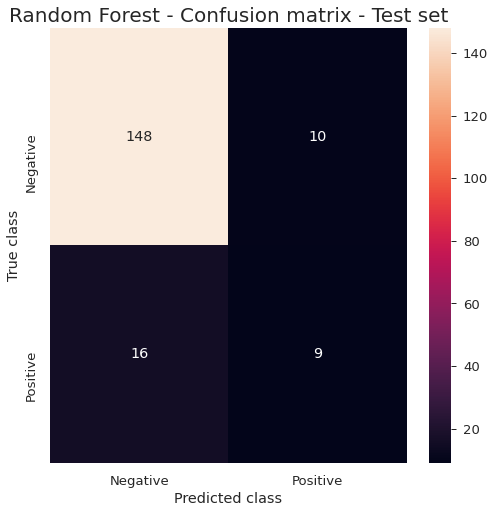

No Skill: ROC AUC=0.500
Random Forest : ROC AUC=0.893


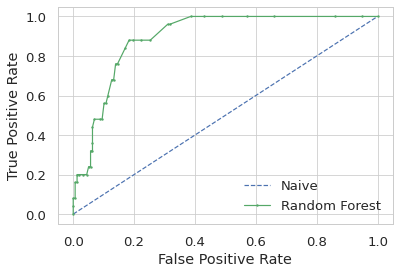

In [ ]:
evalute_model_performance(best_random_forest, 'Random Forest',X_test_norm,y_test)

#### 3 **XGBoost**

![](https://miro.medium.com/max/1554/0*bpEDPjgIvbJOPaWz.png)

In [ ]:
#model's hyperparameters
xgboost_params = {
    'n_estimators' : list(range(10,101,10)),
    'max_depth':[2**i for i in range(1,7)],
    'learning_rate':[0.1, 0.05 ,0.01]
}

best_xgboost,best_xgboost_params,best_xgboost_score = model_fit_with_grid_search_nested_cv(
    XGBClassifier(),
    xgboost_params,
    X_train_norm.values,
   y_train.values.ravel(),
   folds = 5,
   score = f1_scorer,
   verbose = 1)

Fitting 10 folds for each of 180 candidates, totalling 1800 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:  3.5min finished


--- Ellapsed time: 901.4223351478577 seconds ---
Best params:  {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 90}
Best score (make_scorer(fbeta_score, beta=1)) 0.9352549268031847
Nested Cross Validation Accuracy: 0.931 (0.009)



Performance Report: 
Accuracy: 0.858
Recall: 0.699
Precision: 0.699
F1: 0.699
F2: 0.699



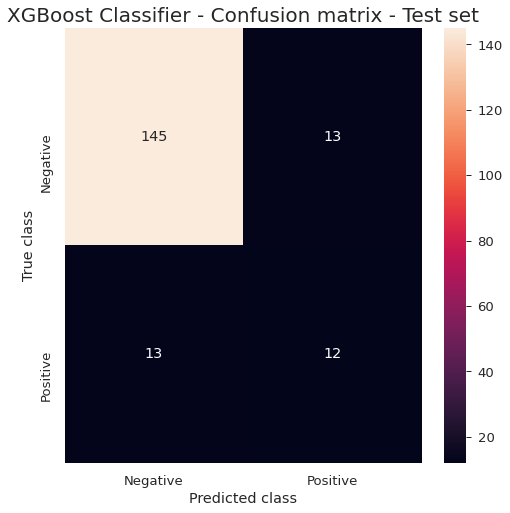

No Skill: ROC AUC=0.500
XGBoost Classifier : ROC AUC=0.891


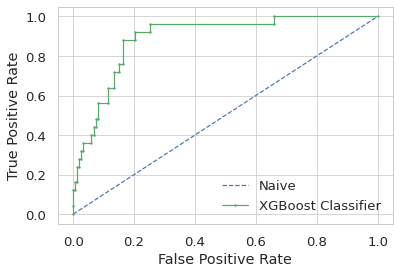

In [ ]:
evalute_model_performance(best_xgboost, 'XGBoost Classifier', X_test_norm.values, y_test)

##**Section 2** - Feature Engineering

In [ ]:
eng_df = final_df.copy()
eng_df['Hematocrit_rbc'] = (final_df['Hematocrit'] + final_df['Red blood Cells']) / 2
eng_df['Basophils _in_Leukocytes'] = final_df['Basophils'] / final_df['Leukocytes']
eng_df['Hemoglobin_in_rbc'] = final_df['Hemoglobin'] * final_df['Red blood Cells']
eng_df['Lymphocytes_Eosinophils'] = final_df['Lymphocytes'] / final_df['Eosinophils']
eng_df['Creatinine_Urea'] = (final_df['Urea']*1000) / final_df['Creatinine'] # *1000 - mmol to umol

# encoding
eng_df.loc[eng_df['Creatinine_Urea'] < 10, 'Creatinine_Urea'] = 0
eng_df.loc[eng_df['Creatinine_Urea'] >= 10, 'Creatinine_Urea'] = 1
eng_df.loc[eng_df['Creatinine_Urea'] > 21, 'Creatinine_Urea'] = 0

In [ ]:
y = eng_df[class_label]
X = eng_df.drop(class_label, axis=1)

In [ ]:
y = LabelEncoder().fit_transform(y)
X, y = pd.DataFrame(data=X, columns=eng_df.drop(class_label, axis=1).columns) ,pd.DataFrame(data=y, columns=[class_label])

In [ ]:
scaler = MinMaxScaler()
scaler.fit(X)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [ ]:
X_train, X_test = imputer(X_train, X_test)

In [ ]:
X_train, y_train = SVMSMOTE().fit_resample(X_train, y_train)
X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)
X_train_norm = pd.DataFrame(data=scaler.transform(X_train),columns=X_train.columns)
X_test_norm = pd.DataFrame(data=scaler.transform(X_test),columns=X_test.columns)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.


In [ ]:
X_train.columns = X.columns
X_test.columns = X.columns

### 1 **LogisticRegression**

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 80 candidates, totalling 800 fits


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got elasticnet penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

Estimator fit fail

--- Ellapsed time: 31.361082553863525 seconds ---
Best params:  {'C': 100, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}
Best score (make_scorer(fbeta_score, beta=1)) 0.8857271036218405
Nested Cross Validation Accuracy: 0.884 (0.020)

Performance Report: 
Accuracy: 0.863
Recall: 0.803
Precision: 0.726
F1: 0.754
F2: 0.780



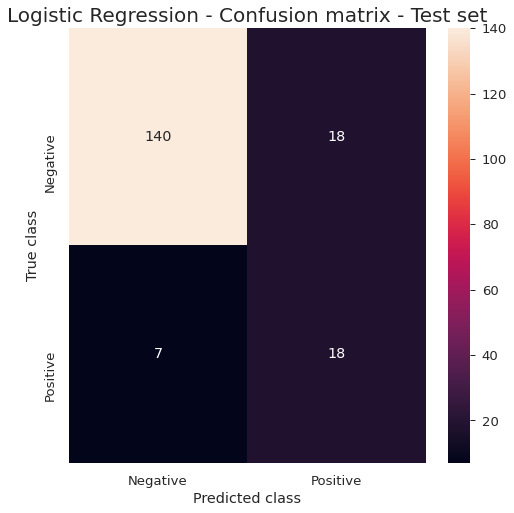

No Skill: ROC AUC=0.500
Logistic Regression : ROC AUC=0.906


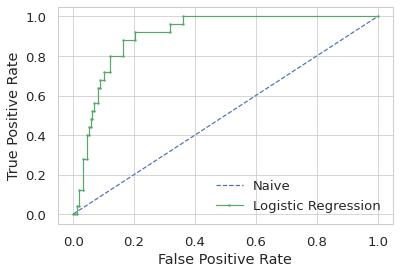

In [ ]:
# Creating a Grid Search for hyperparameter tuning
best_lr,best_lr_params,best_lr_score = model_fit_with_grid_search_nested_cv(
    LogisticRegression(),
    logistic_regression_params,
    X_train_norm.values,
    y_train.values.ravel(),
    folds = 5,
    score = f1_scorer,
    verbose = 1)
evalute_model_performance(best_lr, 'Logistic Regression',X_test_norm,y_test)

### 2 **RandomForestClassifier**

Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:  1.4min finished


--- Ellapsed time: 411.4394180774689 seconds ---
Best params:  {'max_depth': 32, 'n_estimators': 90}
Best score (make_scorer(fbeta_score, beta=1)) 0.9520844890751791
Nested Cross Validation Accuracy: 0.941 (0.014)

Performance Report: 
Accuracy: 0.880
Recall: 0.695
Precision: 0.747
F1: 0.716
F2: 0.702



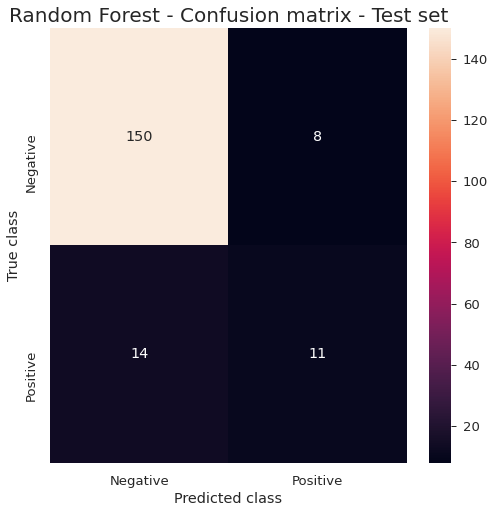

No Skill: ROC AUC=0.500
Random Forest : ROC AUC=0.909


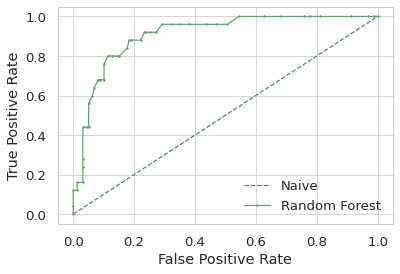

In [ ]:
best_random_forest,best_random_forest_params,best_random_forest_score = model_fit_with_grid_search_nested_cv(
    RandomForestClassifier(),
    random_forest_params,
    X_train_norm.values,
    y_train.values.ravel(),
    folds = 5,
    score = f1_scorer,
    verbose = 1)
evalute_model_performance(best_random_forest, 'Random Forest',X_test_norm,y_test)

### 3 **XGBClassifier**

Fitting 10 folds for each of 180 candidates, totalling 1800 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:  4.1min finished


--- Ellapsed time: 1061.8299374580383 seconds ---
Best params:  {'learning_rate': 0.1, 'max_depth': 16, 'n_estimators': 100}
Best score (make_scorer(fbeta_score, beta=1)) 0.9410457620284586
Nested Cross Validation Accuracy: 0.933 (0.018)

Performance Report: 
Accuracy: 0.907
Recall: 0.744
Precision: 0.825
F1: 0.776
F2: 0.755



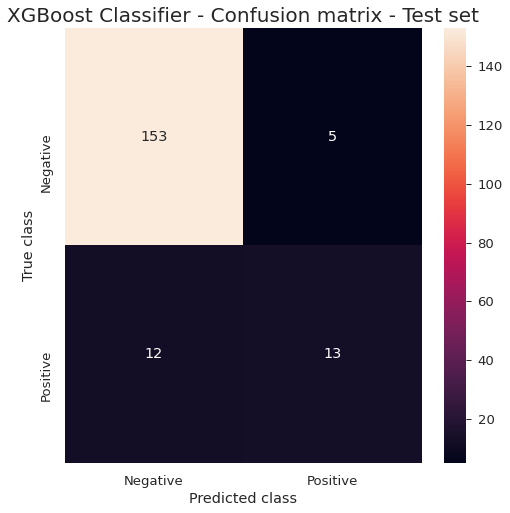

No Skill: ROC AUC=0.500
XGBoost Classifier : ROC AUC=0.908


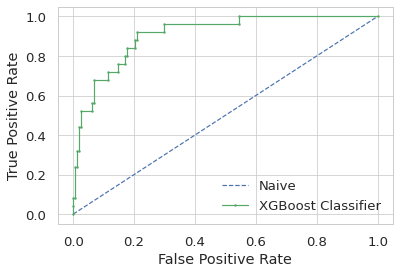

In [ ]:
best_xgboost,best_xgboost_params,best_xgboost_score = model_fit_with_grid_search_nested_cv(
    XGBClassifier(),
    xgboost_params,
    X_train_norm.values,
   y_train.values.ravel(),
   folds = 5,
   score = f1_scorer,
   verbose = 1)
evalute_model_performance(best_xgboost, 'XGBoost Classifier', X_test_norm.values, y_test)

## **Section 3** - Additional Models

### 1 **CatBoostClassifier**

![](https://miro.medium.com/max/2686/1*6fsHRHo67XviEZtP7Qz8Tw.png)

In [ ]:
#model's hyperparameters
catboost_params = {
    # 'max_depth':[2**i for i in range(1,4)],
    'n_estimators' : [90],
    'learning_rate':[0.05],    
    # 'n_estimators' : list(range(70,101,10)),
    # 'learning_rate':[0.1, 0.05 ,0.01]
}

best_catboost,best_catboost_params,best_catboost_score = model_fit_with_grid_search_nested_cv(
    CatBoostClassifier(),
    catboost_params,
    X_train_norm.values,
    y_train.values.ravel(),
    folds = 5,
    score = f1_scorer,
    verbose = 1)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0:	learn: 0.6536681	total: 56.3ms	remaining: 5.01s
1:	learn: 0.6181421	total: 62.4ms	remaining: 2.75s
2:	learn: 0.5810791	total: 68.8ms	remaining: 1.99s
3:	learn: 0.5444398	total: 75ms	remaining: 1.61s
4:	learn: 0.5160344	total: 81.2ms	remaining: 1.38s
5:	learn: 0.4918817	total: 87.3ms	remaining: 1.22s
6:	learn: 0.4685271	total: 93.4ms	remaining: 1.11s
7:	learn: 0.4496687	total: 99.5ms	remaining: 1.02s
8:	learn: 0.4306126	total: 106ms	remaining: 952ms
9:	learn: 0.4131936	total: 112ms	remaining: 896ms
10:	learn: 0.3980390	total: 118ms	remaining: 851ms
11:	learn: 0.3810711	total: 125ms	remaining: 812ms
12:	learn: 0.3692411	total: 131ms	remaining: 777ms
13:	learn: 0.3581169	total: 137ms	remaining: 746ms
14:	learn: 0.3436798	total: 144ms	remaining: 718ms
15:	learn: 0.3292720	total: 150ms	remaining: 692ms
16:	learn: 0.3174712	total: 159ms	remaining: 681ms
17:	learn: 0.3047834	total: 165ms	remaining: 660ms
18:	learn: 0.2959694	total: 171ms	remaining: 640ms
19:	learn: 0.2861125	total: 177ms	r

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   10.8s finished


0:	learn: 0.6475236	total: 7.07ms	remaining: 629ms
1:	learn: 0.6099797	total: 13.8ms	remaining: 605ms
2:	learn: 0.5746857	total: 20.1ms	remaining: 582ms
3:	learn: 0.5405394	total: 26.5ms	remaining: 569ms
4:	learn: 0.5124862	total: 33ms	remaining: 561ms
5:	learn: 0.4885350	total: 39.2ms	remaining: 548ms
6:	learn: 0.4667316	total: 45.4ms	remaining: 538ms
7:	learn: 0.4512054	total: 51.6ms	remaining: 529ms
8:	learn: 0.4309041	total: 58ms	remaining: 522ms
9:	learn: 0.4141000	total: 64.1ms	remaining: 513ms
10:	learn: 0.3961077	total: 70.2ms	remaining: 504ms
11:	learn: 0.3812238	total: 81.5ms	remaining: 530ms
12:	learn: 0.3693154	total: 88.1ms	remaining: 522ms
13:	learn: 0.3594281	total: 94.7ms	remaining: 514ms
14:	learn: 0.3459154	total: 105ms	remaining: 525ms
15:	learn: 0.3334675	total: 112ms	remaining: 517ms
16:	learn: 0.3211671	total: 118ms	remaining: 508ms
17:	learn: 0.3099129	total: 125ms	remaining: 499ms
18:	learn: 0.3008730	total: 131ms	remaining: 491ms
19:	learn: 0.2947846	total: 138


Performance Report: 
Accuracy: 0.896
Recall: 0.772
Precision: 0.781
F1: 0.776
F2: 0.773



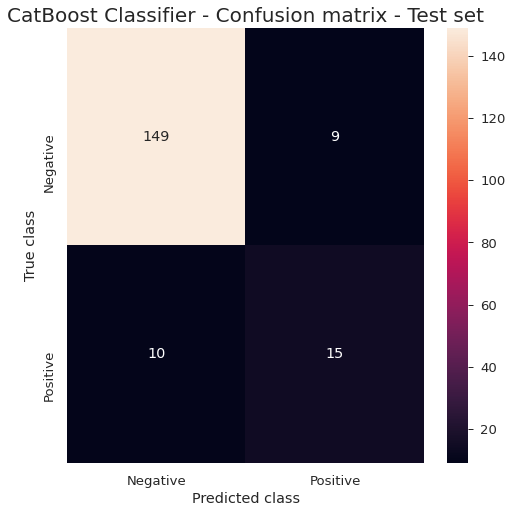

No Skill: ROC AUC=0.500
CatBoost Classifier : ROC AUC=0.912


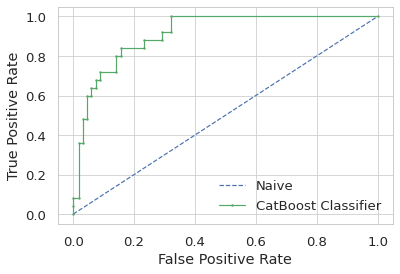

In [ ]:
evalute_model_performance(best_catboost, 'CatBoost Classifier',X_test_norm,y_test)

### 2 **LGBMClassifier**

![](https://hippocampus-garden.com/static/c72041caf5e5a40fa3f7397c2209fadc/14b42/ogp.jpg)

In [ ]:
#model's hyperparameters
lgbc_params = {
    'n_estimators' : list(range(10,101,10)),
    'max_depth':[2**i for i in range(1,7)],
    'learning_rate':[0.1, 0.05 ,0.01]
}

best_lgbc,best_lgbc_params,best_lgbc_score = model_fit_with_grid_search_nested_cv(
    LGBMClassifier(),
    lgbc_params,
    X_train_norm.values,
    y_train.values.ravel(),
    folds = 5,
    score = f1_scorer,
    verbose = 1)

Fitting 10 folds for each of 180 candidates, totalling 1800 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:  2.8min finished


--- Ellapsed time: 667.8345878124237 seconds ---
Best params:  {'learning_rate': 0.1, 'max_depth': 16, 'n_estimators': 70}
Best score (make_scorer(fbeta_score, beta=1)) 0.9451656028498133
Nested Cross Validation Accuracy: 0.928 (0.011)



Performance Report: 
Accuracy: 0.907
Recall: 0.795
Precision: 0.805
F1: 0.800
F2: 0.797



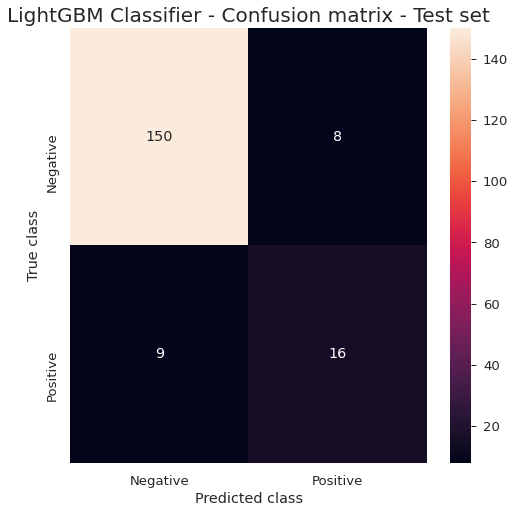

No Skill: ROC AUC=0.500
LightGBM Classifier : ROC AUC=0.932


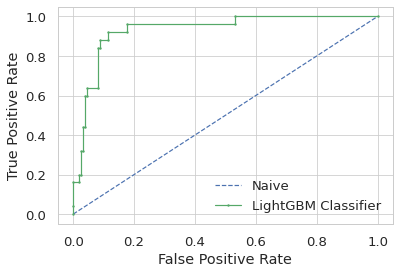

In [ ]:
evalute_model_performance(best_lgbc, 'LightGBM Classifier',X_test_norm,y_test)

## **Section 4** - Model Explanation using SHAP
![](https://raw.githubusercontent.com/slundberg/shap/master/docs/artwork/shap_header.png)

In [ ]:
  # load JS visualization code to notebook
  shap.initjs()

In [ ]:
def shap_explain(model, data):
  model_name = type(model).__name__
  try:
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(data)  
    
    shap.summary_plot(shap_values, data,max_display=30, title = model_name +' Summary Plot')
    shap.summary_plot(shap_values, data, plot_type="bar",max_display=30, title = model_name +' Summary Bar Plot') 

    shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(data[data.columns])
    shap.summary_plot(shap_interaction_values, data[data.columns], max_display=10, title = model_name +' Platelets Dependence Plot')
    shap.dependence_plot("Platelets", shap_values, data, title = model_name +' Platelets Dependence Plot')
    shap.dependence_plot("Leukocytes", shap_values, data, title = model_name +' Leukocytes Dependence Plot')
    shap.dependence_plot("Eosinophils", shap_values, data, title = model_name +' Eosinophils Dependence Plot')
    shap.dependence_plot("Monocytes", shap_values, data, title = model_name +' Monocytes Dependence Plot')
    shap.force_plot(explainer.expected_value, shap_values[0,:], data.iloc[0,:])
  except: pass

### 1 **RandomForestClassifier**

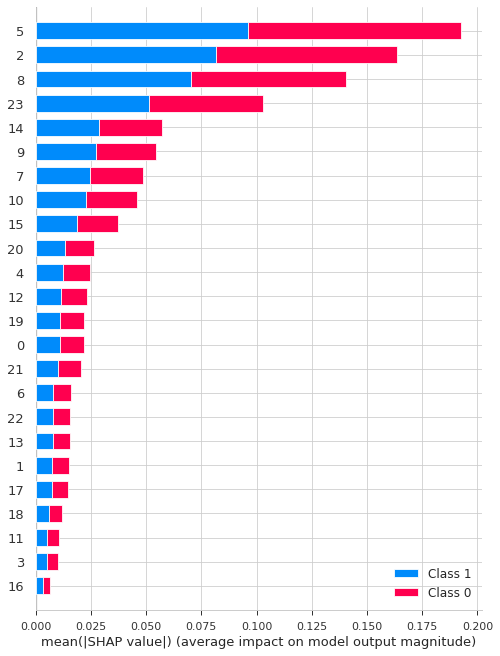

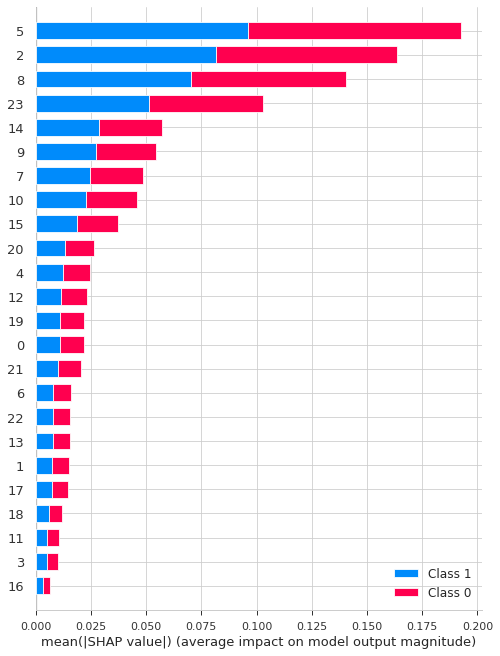

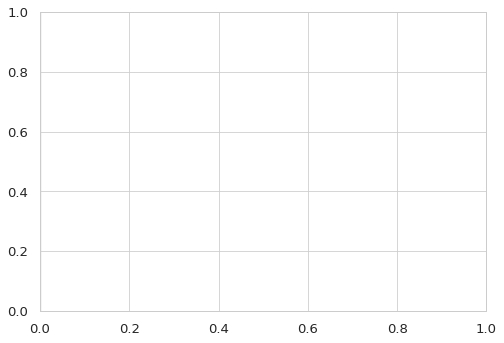

In [ ]:
shap_explain(best_random_forest, X_train_norm)

### 2 **XGBClassifier**

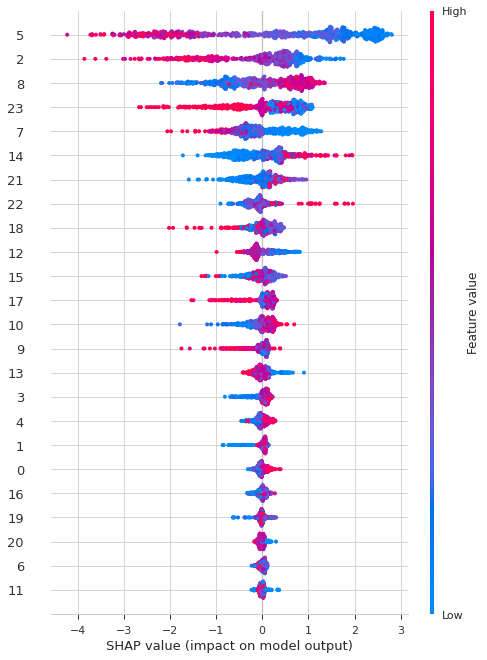

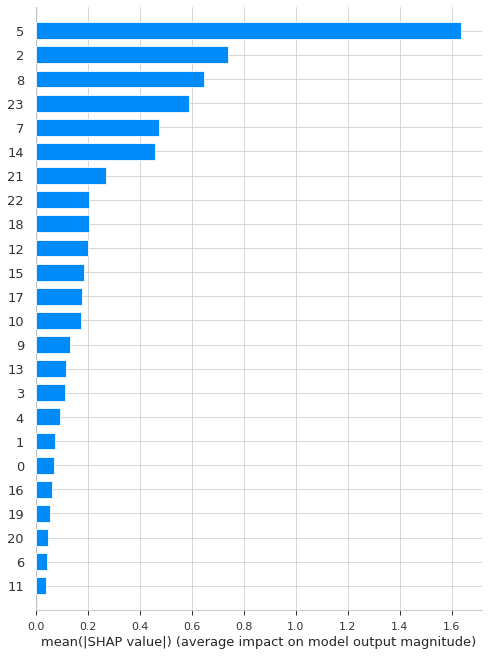

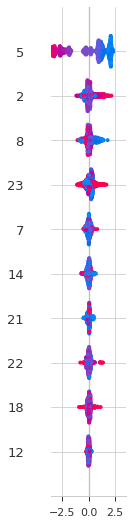

In [ ]:
shap_explain(best_xgboost, X_train_norm)

### 3 **CatBoostClassifier**

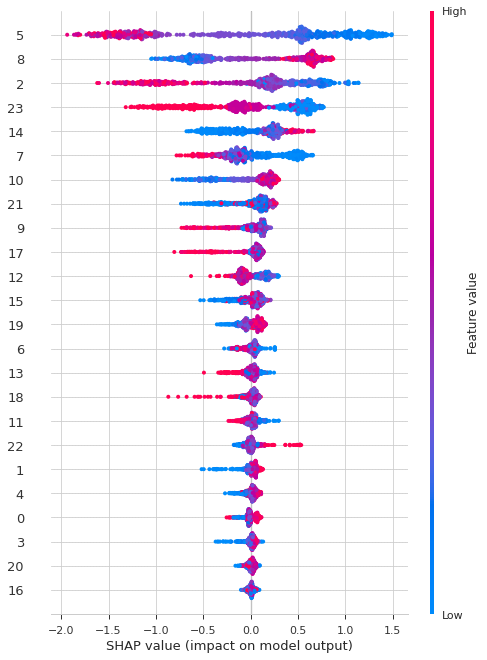

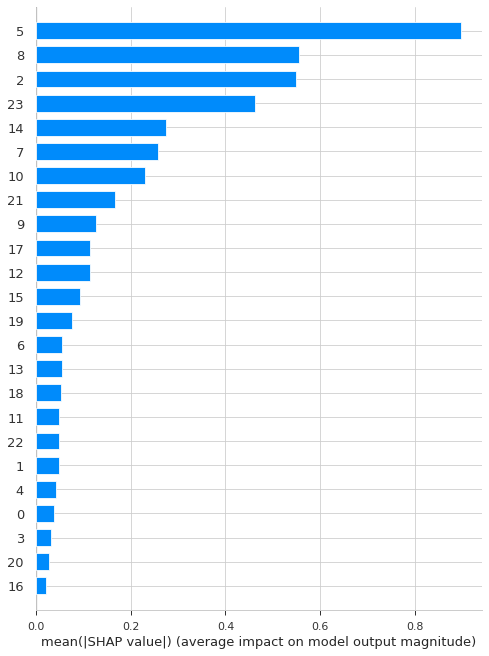

In [ ]:
shap_explain(best_catboost, X_train_norm)

### 4 **LGBMClassifier**

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


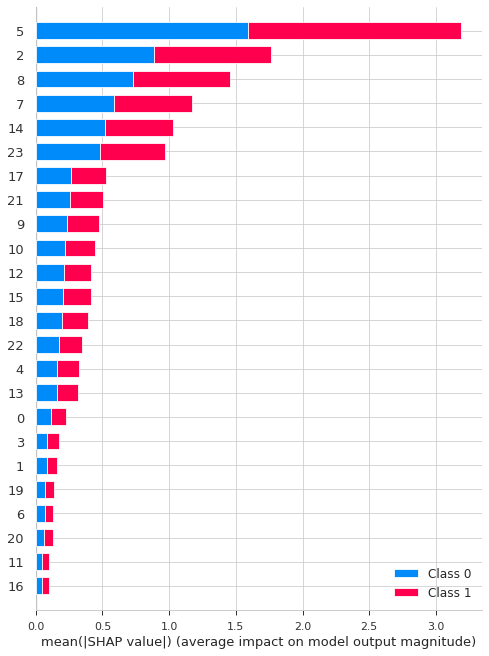

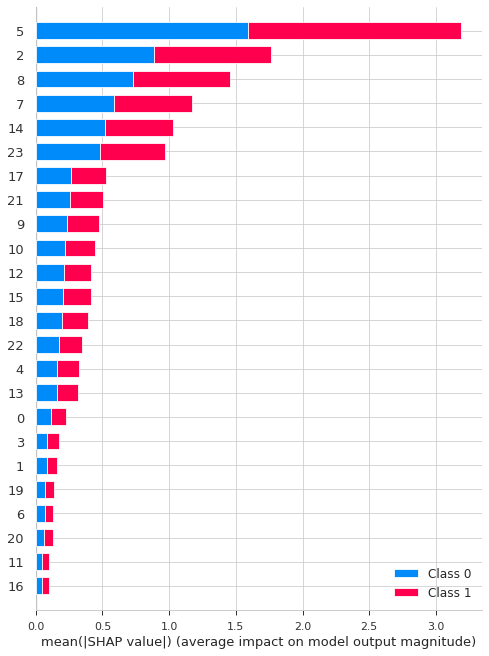

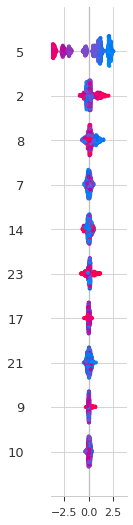

In [ ]:
shap_explain(best_lgbc, X_train_norm)